In [1]:
import ctypes
ctypes.cdll.LoadLibrary("/apps/gilbreth/cuda-toolkit/cuda-11.2.0/lib64/libcusparse.so.11");

In [2]:
import random
import multiprocessing
import pandas as pd
import os
from tqdm import tqdm
import torch
import argparse
from argparse import ArgumentParser
from pathlib import Path
import torch.nn.functional as F
import DeviceDir

DIR, RESULTS_DIR = DeviceDir.get_directory()
device, NUM_PROCESSORS = DeviceDir.get_device()

# Dataset

In [3]:
from ipynb.fs.full.Dataset import get_data, generate_synthetic
from ipynb.fs.full.Utils import save_plot

import ipynb.fs.full.utils.MoonGraph as MoonGraph
import networkx as nx
from torch_geometric.utils import to_networkx, from_networkx
import torch_geometric.utils.homophily as homophily
#https://www.datacamp.com/tutorial/pytorch-tutorial-building-a-simple-neural-network-from-scratch

In [4]:
import torch.nn as nn
import numpy as np
from torch.nn import init
from random import shuffle, randint
import torch.nn.functional as F
from torch_geometric.datasets import Reddit, PPI, Planetoid
from itertools import combinations, combinations_with_replacement
from sklearn.metrics import f1_score, accuracy_score
from sklearn.decomposition import TruncatedSVD
#from torch_geometric.data import NeighborSampler
import matplotlib.pyplot as plt
import sys
from torch_geometric.data import Data
import logging
import time
import copy
import math
from torch_sparse import SparseTensor

from torch_geometric.loader import NeighborSampler, NeighborLoader
from ipynb.fs.full.AGS_Node_Sampler import WeightedNeighborLoader
from torch_geometric.utils import degree

In [5]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

In [6]:
random.seed(1)
np.random.seed(1)
torch.manual_seed(1)
LOG_INFO = True

## Command Line Arguments and settings

In [7]:
def get_configuration():
    parser = ArgumentParser()
    parser.add_argument('--epochs', type=int, default=1)
    parser.add_argument('--pbar', type=bool, default=True)
    parser.add_argument('--batch_size', type=int, default=32)
    parser.add_argument('--auto_batch', type=int, default=-1)
    parser.add_argument('--learning_rate', type=float, default=2e-5)
    parser.add_argument('--num_gpus', type=int, default=-1)
    parser.add_argument('--parallel_mode', type=str, default="dp", choices=['dp', 'ddp', 'ddp2'])
    parser.add_argument('--dataset', type=str, default="Moon", choices=['Reddit','Cora','CiteSeer','PubMed'])
        
    parser.add_argument('-f') ##dummy for jupyternotebook
    args = parser.parse_args()
    
    dict_args = vars(args)
    
    return args, dict_args

args, dict_args = get_configuration()

# Sparsification modules

In [8]:
from ipynb.fs.full.SubmodularWeights import SubModularWeightFacilityFaster
from ipynb.fs.full.KNNWeights import KNNWeight
from ipynb.fs.full.PretrainedLink import LinkPred, LinkNN, LinkSub
from ipynb.fs.full.RandomSparse import RandomSparse

In [9]:
from ipynb.fs.full.Dataset import test_uniformity, total_entropy, agg_homophily

## GNNmodel

In [10]:
from torch_geometric.nn import GCNConv, GATConv, SAGEConv, GINConv
from torch_geometric.nn import GraphConv, TransformerConv
from torch_geometric.utils import degree
import torch.nn.functional as F
from sklearn.metrics import accuracy_score
from ipynb.fs.full.SpatialConv import SpatialConv

In [11]:
# test = AGS_GCN(2, 2)
# #print(test)
# n=7
# x = torch.Tensor([[1,0],[1,0],[1,0],[0,1],[0,1],[0,1],[0,1]])
# y = torch.LongTensor([0,0,0, 1, 1, 1, 1])
# edge_index = torch.LongTensor([[1,2],[1,4],[1,5],[2,1],[3,6],[3,7],[4,5],[4,1],[4,6],[4,7],[5,1],[5,4],[5,6],[6,3],[6,4],[6,5],[6,7],[7,3],[7,4],[7,6]]).T
# edge_index = edge_index-1
# test(x,edge_index)

In [12]:
# import layers
# import scipy.sparse as sp
# from ipynb.fs.full.ACM.models.Test import GCN, normalize_tensor, sparse_mx_to_torch_sparse_tensor
# from torch_geometric.utils.convert import to_scipy_sparse_matrix

In [13]:
# test2  = GCN(nfeat=2,
#         nhid=2,
#         nclass=2,
#         nlayers=2,
#         nnodes=7,
#         dropout=0.2,
#         model_type='acmgcn',
#         structure_info=0,
#         variant=False,
#         init_layers_X=1,)

# test2 = test2.to(device)
# test2

In [14]:
#import ACM.modelgeom.layers as layers
from ACM.modelgeom.models import GCN
import scipy.sparse as sp
from torch_geometric.utils.convert import to_scipy_sparse_matrix
from ipynb.fs.full.ACM.models.Test import normalize_tensor, sparse_mx_to_torch_sparse_tensor

In [15]:
# test2  = GCN(nfeat=2,
#         nhid=2,
#         nclass=2,
#         nlayers=2,
#         nnodes=7,
#         dropout=0.2,
#         model_type='acmgcn',
#         structure_info=0,
#         variant=False,)

# test2 = test2.to(device)
# test2

In [16]:
# adj_low_unnormalized = to_scipy_sparse_matrix(edge_index)
# adj_low = normalize_tensor(sp.identity(n) + adj_low_unnormalized)
# adj_high = sp.identity(n) - adj_low
# adj_low = sparse_mx_to_torch_sparse_tensor(adj_low).to(device)
# adj_high = sparse_mx_to_torch_sparse_tensor(adj_high).to(device)
# adj_low_unnormalized = sparse_mx_to_torch_sparse_tensor(adj_low_unnormalized).to(device)

# test2(x.to(device), adj_low, adj_high, adj_low_unnormalized)

In [17]:
def ACMtest(model, data, mask, x, adj_low, adj_high, adj_low_unnormalized):
    
    model.eval()
    
    total_correct=0
    total_examples=0
    
    with torch.no_grad():                  
    
        out = model(x, adj_low, adj_high, adj_low_unnormalized)  
        out = F.log_softmax(out,dim=1)
        pred =out[mask].argmax(dim=1)            
        
        correct = pred.eq(data.y[mask].to(device))
        total_correct+=correct.sum()            

        total_examples += sum(mask)

    #print("Total tested: ", total_examples,end=', ')

    return total_correct/total_examples

    

def ACMtrain(model, data, epochs=100, train_neighbors=[-1,10], test_neighbors=[-1,10]):
    
    if LOG_INFO:
        print("Train neighbors: ", train_neighbors)
        print("Test neighbors: ", test_neighbors)
    
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
    
    if data.y.ndim == 1:
        #criterion = torch.nn.CrossEntropyLoss()
        criterion = torch.nn.NLLLoss()
    else:
        criterion = torch.nn.BCEWithLogitsLoss()
        
    
    row, col = data.edge_index
    data.edge_weight = 1. / degree(col, data.num_nodes)[col]  # Norm by in-degree.
    
    train_losses=[]
    val_accuracies=[]
    train_accuracies=[]
    test_accuracies=[]
    
    
    data = data.to(device)
    n = data.num_nodes
    x = data.x.to(device)
    adj_low_unnormalized = to_scipy_sparse_matrix(data.edge_index)
    adj_low = normalize_tensor(sp.identity(n) + adj_low_unnormalized)
    adj_high = sp.identity(n) - adj_low
    adj_low = sparse_mx_to_torch_sparse_tensor(adj_low).to(device)
    adj_high = sparse_mx_to_torch_sparse_tensor(adj_high).to(device)
    adj_low_unnormalized = sparse_mx_to_torch_sparse_tensor(adj_low_unnormalized).to(device)
    
    if LOG_INFO:
        print(x.device, adj_low.device, adj_high.device, adj_low_unnormalized.device)
    
    for epoch in range(1,epochs+1):
        
        model.train()
        total_loss = total_examples = 0
        
        optimizer.zero_grad()
                
        out = model(x, adj_low, adj_high, adj_low_unnormalized)
    
        #loss = F.nll_loss(out[batch_data.train_mask], batch_data.y[batch_data.train_mask])
        out = F.log_softmax(out,dim=1)
        loss = criterion(out[data.train_mask], data.y[data.train_mask])

        loss.backward()
        optimizer.step()

        total_loss += loss.item() * int(sum(data.train_mask))
        total_examples += int(sum(data.train_mask))
        loss=total_loss / total_examples
        train_losses.append(loss)
        
        model.eval()
        with torch.no_grad():            
            out = model(x, adj_low, adj_high, adj_low_unnormalized)
            #out = F.log_softmax(out,dim=1)        
            pred = out.argmax(dim=-1)
            correct = pred.eq(data.y)

        accs = []
        for _, mask in data('train_mask', 'val_mask', 'test_mask'):
            accs.append(correct[mask].sum().item() / mask.sum().item()) 
            
        #print(accs)
        train_accuracies.append(accs[0])
        val_accuracies.append(accs[1])
        test_accuracies.append(accs[2])
        std_dev = np.std(train_losses[-5:])
        
        if LOG_INFO:
            print(f'Epoch: {epoch:03d}, Train Loss: {loss:.4f}, Train: {accs[0]:.4f}, Val: {accs[1]:.4f}, Test: {accs[2]:.4f}, Std dev: {std_dev:.4f}')
    
#         train_acc = ACMtest(model, data, data.train_mask, x, adj_low, adj_high, adj_low_unnormalized)
#         train_accuracies.append(train_acc.item())

#         val_acc = ACMtest(model, data, data.val_mask, x, adj_low, adj_high, adj_low_unnormalized)
#         val_accuracies.append(val_acc.item())
        
#         test_acc = ACMtest(model, data, data.test_mask, x, adj_low, adj_high, adj_low_unnormalized)
#         test_accuracies.append(test_acc.item())
        
#         std_dev = np.std(train_losses[-5:])
        
#         print(f'Epoch: {epoch:03d}, Train Loss: {loss:.4f}, Train: {train_acc:.4f}, Val: {val_acc:.4f}, Test: {test_acc:.4f}, Std dev: {std_dev:.4f}')
    
    if LOG_INFO:
        save_plot([train_losses, train_accuracies, val_accuracies, test_accuracies], labels=['Loss','Train','Validation','Test'], name='Plots/Validation', yname='Accuracy', xname='Epoch')

        print ("Best Validation Accuracy, ",max(val_accuracies))
        print ("Best Test Accuracy, ",max(test_accuracies))
    
    return max(test_accuracies), 0

In [18]:
def ACMperformanceSampler(data, dataset, epochs=1, train_neighbors=[-1,10], test_neighbors=[-1,10]):        
    
#     model  = GCN(
#         nfeat=dataset.num_features,
#         nhid=64,
#         nclass=dataset.num_classes,
#         nlayers=2,
#         nnodes=data.num_nodes,
#         dropout=0.2,
#         model_type='acmsnowball',
#         structure_info=0,
#         variant=False,
#         init_layers_X=1,)

    #acmgcnpp acmgcn acmgcnp acmsgc acmsnowball

    model  = GCN(
        nfeat=dataset.num_features,
        nhid=64,
        nclass=dataset.num_classes,
        nlayers=2,
        nnodes=data.num_nodes,
        dropout=0.2,
        model_type='acmgcnp',
        structure_info=1,
        variant=True,)
    
    model = model.to(device)
    
    if LOG_INFO:
        print(model)
        
    test_acc, itr = ACMtrain(model, data, epochs, train_neighbors=train_neighbors, test_neighbors=test_neighbors)
    
    return test_acc, itr

In [31]:
data, dataset = get_data('Squirrel', DIR, log=True, h_score=True, split_no=2)
# data = generate_synthetic(data, d=42, h=0.2, train=0.6, random_state=1, log=True)
# data.x = F.one_hot(data.y).float()
data

Looking at:  /scratch/gilbreth/das90/Dataset/
Data directory:  /scratch/gilbreth/das90/Dataset/
Result directory: /scratch/gilbreth/das90/Dataset/RESULTS/

Dataset: WikipediaNetwork():
Number of graphs: 1
Number of features: 2089
Number of classes: 5

Data(x=[5201, 2089], edge_index=[2, 217073], y=[5201], train_mask=[5201], val_mask=[5201], test_mask=[5201])
Number of nodes: 5201
Number of edges: 217073
Average node degree: 41.74
Number of training nodes: 2496
Training node label rate: 0.48
Has isolated nodes: False
Has self-loops: True
Is undirected: False
0.08891735225915909 0.2239430993795395 0.042996399104595184 0.3737970292568207


Data(x=[5201, 2089], edge_index=[2, 217073], y=[5201], train_mask=[5201], val_mask=[5201], test_mask=[5201])

In [32]:
# #submodular_weight = LinkPred(data)
# nn_weight = LinkSub(data, value='max', selfloop = False, log=True) #min favor similar ones, max disimilar    
# #     data.weight = nn_weight.compute_weights()
# #     data.X = None
# #     nn_weight.# submodular_weight.lazy_greedy_weight(0)
# nn_weight

In [33]:
def sparsify(data, log = True, method = 'NN', metric= None):
    data.to('cpu')    
    
    if metric is None:
        metric = 'cosine'
    
    if method == 'nn':
        submodular_weight = KNNWeight(data, metric=metric, log=log)                
        data.weight = submodular_weight.compute_weights()        

    elif method == 'submodular':
        submodular_weight = SubModularWeightFacilityFaster(data, metric=metric, log=log)
        data.weight = submodular_weight.compute_weights()        
    
    elif method == 'link-nn':    
        submodular_weight = LinkPred(data, selfloop = True, log=log)
        data.weight = submodular_weight.compute_weights()        
        nn_weight = LinkNN(data, value='min', log=log) #min favor similar ones, max disimilar
        data.weight = nn_weight.compute_weights()
    elif method == 'link-sub':    
        nn_weight = LinkSub(data, value='max', selfloop = True, log=log) #min favor similar ones, max disimilar    
        data.weight = nn_weight.compute_weights()
    else:
        raise 'Not implemented error'
    
    cp_data= copy.deepcopy(data)
    G = to_networkx(cp_data, to_undirected=False, edge_attrs=['weight'])
    to_remove = [(a,b) for a, b, attrs in G.edges(data=True) if attrs["weight"] < 0.7 ]
    G.remove_edges_from(to_remove)
    updated_data = from_networkx(G)
    
    updated_data = from_networkx(G, group_edge_attrs=['weight'])
    updated_data.weight = updated_data.edge_attr.view(-1)

    row, col = updated_data.edge_index
    updated_data.edge_index = torch.stack((torch.cat((row, col),dim=0), torch.cat((col, row),dim=0)),dim=0)
    updated_data.weight = torch.cat((updated_data.weight, updated_data.weight),dim=0)

    
    if LOG_INFO:
        print(updated_data)
        print("Node Homophily:", homophily(updated_data.edge_index, data.y, method='node'))
        print("Edge Homophily:", homophily(updated_data.edge_index, data.y, method='edge'))
        print("Edge_insensitive Homophily:", homophily(updated_data.edge_index, data.y, method='edge_insensitive'))    
        print("Degree: ", updated_data.num_edges / updated_data.num_nodes)

    data.edge_index = updated_data.edge_index
    data.edge_weight = updated_data.weight
    data.weight = None

    return data

# LOG_INFO = True
# data = sparsify(data, log = False)
# data

In [34]:
def random_sparsify(data, K, log = False):    
    rand_sparse = RandomSparse(data, K = K, log = log)
    edge_index = rand_sparse.sparse()
    row, col = edge_index
    data.edge_index = torch.stack((torch.cat((row, col),dim=0), torch.cat((col, row),dim=0)),dim=0)
    
    if log:
        print("Node Homophily:", homophily(data.edge_index, data.y, method='node'))
        print("Edge Homophily:", homophily(data.edge_index, data.y, method='edge'))
        print("Edge_insensitive Homophily:", homophily(data.edge_index, data.y, method='edge_insensitive'))    
        print("Degree: ", data.num_edges / data.num_nodes)
    
    return data

In [35]:
def modify_homophily(data, h = 0.1, d = 11, log = False):
    data.to('cpu')
    N = data.num_nodes
    E = data.num_edges
    adj = SparseTensor(
        row=data.edge_index[0], col=data.edge_index[1],
        value=torch.arange(E, device=data.edge_index.device),
        sparse_sizes=(N, N))
    
    edge_index=[]
    
#     h = 0.1
#     d = 11

    match = int(round(d*h))
    unmatch = int(round(d*(1-h)))
    #print(match,unmatch)
    
    for u in range(N):                
        row, col, e_index = adj[u,:].coo()   
        
        cur_y = data.y[u]
        neighbors = data.y[col]
        #print(cur_y, neighbors)
        
        match_indexs = torch.nonzero(neighbors == cur_y).squeeze()
        other_indexs = torch.nonzero(neighbors != cur_y).squeeze()
        
        #print(match_indexs, other_indexs)
        
        if match_indexs.dim()>0:
            m_sel = match_indexs[np.random.choice(len(match_indexs), size=min(match,len(match_indexs)), replace = False)]
        else:
            m_sel = torch.LongTensor([])
        if other_indexs.dim()>0:
            um_sel = other_indexs[np.random.choice(len(other_indexs), size=min(unmatch, len(other_indexs)), replace = False)]
        else:
            um_sel = torch.LongTensor([])
            
        
        #print(m_sel, um_sel)
        
        indexs = torch.cat((m_sel,um_sel),dim=0)
    
        e_index = e_index[indexs]            
        edge_index.extend(e_index)
        
        #break        
            
    edge_index = data.edge_index[:,edge_index]
    row, col = edge_index
    data.edge_index = torch.stack((torch.cat((row, col),dim=0), torch.cat((col, row),dim=0)),dim=0)
    
    if log:
        print("Node Homophily:", homophily(data.edge_index, data.y, method='node'))
        print("Edge Homophily:", homophily(data.edge_index, data.y, method='edge'))
        print("Edge_insensitive Homophily:", homophily(data.edge_index, data.y, method='edge_insensitive'))    
        print("Degree: ", data.num_edges / data.num_nodes)
    
    return data

# data = modify_homophily(data, h=0.15, d=11, log = True)
# data

In [36]:
def adj_feature(data):
    
    adj_mat = torch.zeros((data.num_nodes,data.num_nodes))
    edges = data.edge_index.t()
    adj_mat[edges[:,0], edges[:,1]] = 1
    data.x = adj_mat
    
    return data

# adj_feature(data)
# data.x.shape

In [37]:
# count, score = test_uniformity(data, dataset.num_classes, log=False)
# print(count, score, end = ' ')

In [38]:
def test_hetero():
    d = 42
    for h in np.array(range(0,21))/20:
        DATASET_NAME = 'squirrel'
        data, dataset = get_data(DATASET_NAME, log=False)
        data = generate_synthetic(data, d=d, h = h, train=0.6, random_state=1, log=False, balance = False)
        num_classes = dataset.num_classes
        
        print('d ', d, ' h', h, end=' ')
        count, score = test_uniformity(data, num_classes, log=False)
        print(count, score, end = ' ')
        total_en, en_score = total_entropy(data, num_classes, log=False)
        print(total_en, en_score, end = ' ')
        
        print('sparse', end = ' ')
        data = sparsify(data, log=False)
        
        count, score = test_uniformity(data, num_classes, log=False)
        print(count, score, end = ' ')
        total_en, en_score = total_entropy(data, num_classes, log=False)
        print(total_en, en_score, end = ' ')
        
        print("Nh ", homophily(data.edge_index, data.y, method='node'), end = ' ')
        print("Eh ", homophily(data.edge_index, data.y, method='edge'), end = ' ')
        print("EiH ", homophily(data.edge_index, data.y, method='edge_insensitive'), end = ' ')    
        
        print("Ha ", agg_homophily(data, 'affinity'), end = ' ')
        print("Hl ", agg_homophily(data, 'laplacian'), end =' ')
        
        print("D ", data.num_edges / data.num_nodes, end = '\n')


# LOG_INFO = False
# test_hetero()

In [39]:
# LOG_INFO = True
# data = random_sparsify(data, K = 11, log = True)
# data = sparsify(data, method = 'link-nn', metric='cosine', log = True)
# data = modify_homophily(data, h = 0.05, d = 11, log = True)
# data

GCN(
  (gcns): ModuleList(
    (0): GraphConvolution (2089 -> 64)
    (1): GraphConvolution (64 -> 5)
  )
  (mlps): ModuleList()
)
Train neighbors:  [-1, -1]
Test neighbors:  [-1, -1]
cuda:0 cuda:0 cuda:0 cuda:0
Epoch: 001, Train Loss: 1.6477, Train: 0.2800, Val: 0.2686, Test: 0.2536, Std dev: 0.0000
Epoch: 002, Train Loss: 1.5747, Train: 0.3377, Val: 0.3149, Test: 0.2968, Std dev: 0.0365
Epoch: 003, Train Loss: 1.5428, Train: 0.4303, Val: 0.3936, Test: 0.3525, Std dev: 0.0439
Epoch: 004, Train Loss: 1.5050, Train: 0.4659, Val: 0.4044, Test: 0.3785, Std dev: 0.0524
Epoch: 005, Train Loss: 1.4653, Train: 0.5004, Val: 0.4219, Test: 0.4092, Std dev: 0.0622
Epoch: 006, Train Loss: 1.4287, Train: 0.5184, Val: 0.4303, Test: 0.4102, Std dev: 0.0523
Epoch: 007, Train Loss: 1.3912, Train: 0.5593, Val: 0.4465, Test: 0.4188, Std dev: 0.0537
Epoch: 008, Train Loss: 1.3514, Train: 0.5921, Val: 0.4814, Test: 0.4304, Std dev: 0.0539
Epoch: 009, Train Loss: 1.3136, Train: 0.6262, Val: 0.5042, Test: 0.

Epoch: 090, Train Loss: 0.1481, Train: 0.9972, Val: 0.6875, Test: 0.6647, Std dev: 0.0068
Epoch: 091, Train Loss: 0.1497, Train: 0.9984, Val: 0.6857, Test: 0.6667, Std dev: 0.0059
Epoch: 092, Train Loss: 0.1365, Train: 0.9972, Val: 0.6863, Test: 0.6657, Std dev: 0.0054
Epoch: 093, Train Loss: 0.1490, Train: 0.9988, Val: 0.6899, Test: 0.6667, Std dev: 0.0055
Epoch: 094, Train Loss: 0.1409, Train: 0.9984, Val: 0.6851, Test: 0.6695, Std dev: 0.0052
Epoch: 095, Train Loss: 0.1351, Train: 0.9988, Val: 0.6947, Test: 0.6792, Std dev: 0.0061
Epoch: 096, Train Loss: 0.1361, Train: 0.9992, Val: 0.6899, Test: 0.6782, Std dev: 0.0051
Epoch: 097, Train Loss: 0.1301, Train: 0.9988, Val: 0.6923, Test: 0.6830, Std dev: 0.0064
Epoch: 098, Train Loss: 0.1343, Train: 0.9992, Val: 0.6947, Test: 0.6772, Std dev: 0.0035
Epoch: 099, Train Loss: 0.1260, Train: 0.9992, Val: 0.6953, Test: 0.6782, Std dev: 0.0038
Epoch: 100, Train Loss: 0.1321, Train: 0.9988, Val: 0.7007, Test: 0.6830, Std dev: 0.0035
Epoch: 101

<Figure size 432x288 with 0 Axes>

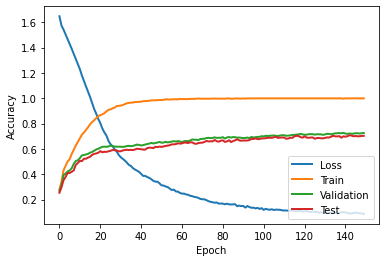

Best Validation Accuracy,  0.7271634615384616
Best Test Accuracy,  0.7079731027857828


In [40]:
LOG_INFO = True
test_acc, itr = ACMperformanceSampler(data, dataset, epochs=150, train_neighbors=[-1,-1], test_neighbors=[-1,-1])

In [29]:
def single_experiments(DATASET_NAME, run = 1):

    if True:   
        d=42; h=0.00
    
#     for h in np.array(range(0,21))/20:    
#     for d in range(110,151,10):            
        print('d ', d, ' h', h, end=' ')
        num_nodes = 0        
        
#         if h<0.51:continue
        
        be_iterations=[];be_accuracies=[];af_iterations=[];af_accuracies=[];before_edge=[];after_edge=[]
        
        Nh = [];Eh = [];EiH =[];D = []; uni_score = []; en_score =[]; Ha_score = []; Hl_score = [];
        
        for r in range(run):    
            #data, dataset = get_data(DATASET_NAME, log=False, train=0.6, random_state=True)                
            data, dataset = get_data(DATASET_NAME, log=False)
#             data = generate_synthetic(data, d=d, h=h, train=0.6, random_state=1, log=False)
            before_edge.append(data.num_edges)
            num_nodes=data.num_nodes

            adj_feature(data)
#             random_sparsify(data, K=int(d*0.25), log = False)
            data = sparsify(data, method = 'nn', metric='cosine', log = False)

#             data = modify_homophily(data, h = max(0,h-0.1), d = 11, log = False)

            Nh.append(homophily(data.edge_index, data.y, method='node'))
            Eh.append(homophily(data.edge_index, data.y, method='edge'))
            EiH.append(homophily(data.edge_index, data.y, method='edge_insensitive'))
            D.append(data.num_edges / data.num_nodes)
            
            score, _ = test_uniformity(data, dataset.num_classes, log=False)
            ent_score, _ = total_entropy(data, dataset.num_classes, log=False)
            uni_score.append(score)
            en_score.append(ent_score)
            
            Ha_score.append(agg_homophily(data, 'affinity'))
            Hl_score.append(agg_homophily(data, 'laplacian'))
        

            accuracy, itr =  ACMperformanceSampler(data, dataset, epochs=150, train_neighbors=[-1,-1], test_neighbors=[-1,-1])
            be_iterations.append(itr)
            be_accuracies.append(accuracy)
        
        print('Nh ', np.mean(Nh), end=' ')
        print('Eh ', np.mean(Eh), end=' ')
        print('Eih ', np.mean(EiH), end=' ')
        print('uni ',np.mean(uni_score), end=' ')
        print('en ',np.mean(en_score), end=' ')
        print('ha ',np.mean(Ha_score), end=' ')
        print('hl ',np.mean(Hl_score), end=' ')
        print('D ', np.mean(D), end=' ')        
        print(f"{num_nodes} {int(np.mean(before_edge))} {int(np.mean(be_iterations))} {np.mean(be_accuracies):0.4f}")

    return None, None, None, None

def batch_experiments():
    
    datasets = [
#         'cora', 
#         'Cora',
#         'citeseer',
#         'CiteSeer',
#         'PubMed',
#         'dblp',
#         'Reddit','Reddit2',
#         'Computers',
#         'Photo',
#         'CS','Physics',
#         'Flickr',
#         'film',
        'cornell',
        'texas',
        'wisconsin',
        'squirrel',
        'chameleon',
#         'Fake',
#         'Moon',
#         'AmazonProducts',
#         'Yelp'
    ]
    
    for DATASET_NAME in datasets:
        print(DATASET_NAME, end='\t')
        before_edge, after_edge, iterations, accuracies = single_experiments(DATASET_NAME, run = 5)
        
        #print(before_edge, after_edge, iterations, accuracies)
        
    
    return 

# start_time = time.time()
# LOG_INFO = False
# batch_experiments()
# LOG_INFO = True
# end_time = time.time()

# print("Time spent: ", end_time-start_time)

In [30]:
if __name__ == '__main__': 
    None